In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as ss
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
UIMatrix = np.load('UIMatrix.npy')

In [4]:
row, col, val = ss.find(UIMatrix)
print(row.shape)

(27743,)


367602.4434910653
235951.3645524891
191194.91943615073
165789.67246407524
147001.1109497575
131901.19882605216
119191.74709960399
108173.63889119336
98434.68015298585
89713.7981282415
81835.18576589468
74674.10728629005
68138.03480860245
62155.675721020176
56670.29495443538
51635.4905778701
47012.42907330684
42767.97988787879
38873.421230773594
35303.51888833112
32035.854856828555
29050.327245482436
26328.770178944153
23854.65949204737
21612.880922445373
19589.54463249186
17771.834636093867
16147.8849235824
14706.676297026881
13437.949484300487
12332.131207200953
11380.270677776673
10573.984580937833
9905.409033596949
9367.157334061163
8952.282560208749
8654.244262133607
8466.878639436798
8384.371705935035
训练时间： 18299.634733200073
[8379.26049672688, 8379.254391601367, 8379.248677638267, 8379.243354795384, 8379.238423031062]
19151


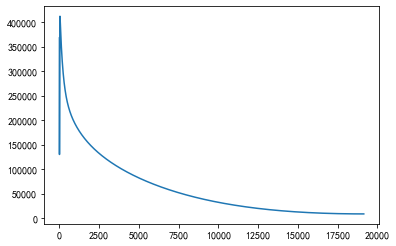

In [8]:
# 逐元素
X = UIMatrix.copy()

def train(loss, lam, k):
    n, m = X.shape
    row, col, val = ss.find(X)

    step = 4e-6
    eps = 5e-3

    # 划分训练集，验证集，测试集
    ziprc = np.array((row, col, val)).T
    np.random.shuffle(ziprc)
    test_size = int(0.18 * ziprc.shape[0])
    validation_size = int(0.18 * ziprc.shape[0])
    test = ziprc[:test_size, :]
    validation = ziprc[test_size:test_size+validation_size, :]
    train = ziprc[test_size+validation_size:, :]

    # 初始化
    P = np.random.rand(n, k)  # 初始化用户矩阵
    Q = np.random.rand(k, m)  # 初始化商品矩阵
    b = np.random.rand(n)
    d = np.random.rand(m)
    u = np.average(X)

    train_x = list(train[:, 0].astype(int))
    train_y = list(train[:, 1].astype(int))

    max_iter = int(5e4)
    lossi_old = 1e6
    start_t = time.time()
    for _ in range(max_iter):
        lossi = 0
        for i, j in zip(train_x, train_y):
            pi = P[i, :]
            qj = Q[:, j]
            eij = X[i, j] - u - b[i] - d[j] - np.dot(pi, qj)
            pi += step * (eij * qj - lam * pi)
            qj += step * (eij * pi - lam * qj)
            b += step * (eij - lam * b)
            d += step * (eij - lam * d)
            lossi += (eij**2 + lam*(np.dot(pi,pi)+np.dot(qj,qj)+np.dot(b,b)+np.dot(d,d)))
        lossi *= 0.5
        loss.append(lossi)
        if np.abs(lossi - lossi_old) < eps:
            break
        lossi_old = lossi
        if _ % 500 == 0:
            print(lossi)
    print("训练时间：", time.time()-start_t)
    return P, Q, validation, test


loss = []
lam = 0.04  # 正则化系数
k = 18  # 隐空间大小
P, Q, validation, test = train(loss, lam, k)
print(loss[-5:])  # 观察最后loss值
print(len(loss))  # 打印迭代次数
plt.plot(range(len(loss)), loss)
plt.show()

# np.save('全批量，无正则化，固定步长loss', np.array(loss))
# np.save('全批量，无正则化，固定步长P', P)
# np.save('全批量，无正则化，固定步长Q', Q)
# np.save('全批量，无正则化，测试集', test)
# np.save('全批量，无正则化，验证集', validation)

In [9]:
np.save('偏置，全批量，无正则化，固定步长loss', np.array(loss))
np.save('偏置，全批量，无正则化，固定步长P', P)
np.save('偏置，全批量，无正则化，固定步长Q', Q)
np.save('偏置，全批量，无正则化，测试集', test)
np.save('偏置，全批量，无正则化，验证集', validation)

In [11]:
# 验证集RMSE
validation_x = list(validation[:, 0].astype(int))
validation_y = list(validation[:, 1].astype(int))
loss = 0
for i, j in zip(validation_x, validation_y):
    r_ij = X[i, j]
    pi = P[i, :]
    qj = Q[:, j]
    r_ij_hat = np.around(pi@qj)
    lossi = (r_ij - r_ij_hat)
    loss += lossi**2 + lam * (np.dot(pi,pi)+np.dot(qj,qj))
    print("r_ij:", r_ij, " r_ij_hat:", r_ij_hat, " loss:", lossi)
print(np.sqrt(loss/len(validation_x)))

r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 5.0  r_ij_hat: 5.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 4.0  r_ij_hat: 5.0  loss: -1.0
r_ij: 3.5  r_ij_hat: 5.0  loss: -1.5
r_ij: 4.5  r_ij_hat: 4.0  loss: 0.5
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 4.0  loss: -2.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.5  r_ij_hat: 4.0  loss: 0.5
r_ij: 1.0  r_ij_hat: 3.0  loss: -2.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 5.0  loss: -2.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 3.0  loss: -1.0
r_ij: 5.0  r_ij_hat: 5.0  loss: 0.0
r_ij: 4.5  r_ij_hat: 4.0  loss: 0.5
r_ij: 3.5  r_ij_hat: 3.0  loss: 0.5
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 4.5  r_ij_hat

In [12]:
# 测试集 RMSE、MAE
test_x = list(test[:, 0].astype(int))
test_y = list(test[:, 1].astype(int))
loss = 0
mae = 0
for i, j in zip(test_x, test_y):
    r_ij = X[i, j]
    pi = P[i, :]
    qj = Q[:, j]
    r_ij_hat = np.around(P[i, :].T @ Q[:, j])
    lossi = (r_ij - r_ij_hat)
    loss += lossi**2+ lam * (np.dot(pi,pi)+np.dot(qj,qj))
    print("r_ij:", r_ij, " r_ij_hat:", r_ij_hat, " loss:", lossi)
    mae += np.abs(lossi)
print(np.sqrt(loss/len(test_x)))
print("MAE:", mae/len(test_x))

r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 3.0  r_ij_hat: 2.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.5  r_ij_hat: 4.0  loss: 0.5
r_ij: 3.5  r_ij_hat: 3.0  loss: 0.5
r_ij: 4.5  r_ij_hat: 3.0  loss: 1.5
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.5  r_ij_hat: 4.0  loss: -0.5
r_ij: 4.0  r_ij_hat: 2.0  loss: 2.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 2.0  loss: 0.0
r_ij: 3.5  r_ij_hat: 4.0  loss: -0.5
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 1.5  r_ij_hat: 3.0  loss: -1.5
r_ij: 3.5  r_ij_hat: 4.0  loss: -0.5
r_ij: 2.5  r_ij_hat: 4.0  loss: -1.5
r_ij: 3.5  r_ij_hat: 3.0  loss: 0.5
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 5.0  loss: -1.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 3.5  r_ij_hat: 3.0  loss: 0.5
r_ij: 4.0  r_ij_hat:

In [14]:
index = np.argsort(P[3,:]@Q)[::-1]
map = np.load("movie_map.npy").astype(int)
movies = pd.read_csv('ml-latest-small/movies.csv')
print("用户4可能最偏好的电影：")
for i in range(10):
    idx = index[i]
    try:
        id = map[map[:,1]==idx][0][0]
        print("电影：", id, list(movies[movies['movieId']==id]['title']),list(movies[movies['movieId']==id]['genres']))
    except:
        pass

用户4可能最偏好的电影：
电影： 408 ['8 Seconds (1994)'] ['Drama']
电影： 2491 ['Simply Irresistible (1999)'] ['Comedy|Romance']
电影： 2677 ['Buena Vista Social Club (1999)'] ['Documentary|Musical']
电影： 3442 ['Band of the Hand (1986)'] ['Action|Crime|Drama']
电影： 387 ['Low Down Dirty Shame, A (1994)'] ['Action|Comedy']
电影： 2314 ['Beloved (1998)'] ['Drama']
电影： 993 ['Infinity (1996)'] ['Drama']
电影： 2185 ['I Confess (1953)'] ['Thriller']
电影： 3051 ['Anywhere But Here (1999)'] ['Comedy|Drama']
电影： 1533 ['Promise, The (La promesse) (1996)'] ['Drama']


In [15]:
usr4 = UIMatrix[3,:]
for i in range(len(usr4)):
    if usr4[i] == 5:
        try:
            id = map[map[:,1]==i][0][0]
            print("电影：", id, list(movies[movies['movieId']==id]['title']),list(movies[movies['movieId']==id]['genres']))
        except:
            pass

电影： 125 ['Flirting With Disaster (1996)'] ['Comedy']
电影： 162 ['Crumb (1994)'] ['Documentary']
电影： 176 ['Living in Oblivion (1995)'] ['Comedy']
电影： 215 ['Before Sunrise (1995)'] ['Drama|Romance']
电影： 232 ['Eat Drink Man Woman (Yin shi nan nu) (1994)'] ['Comedy|Drama|Romance']
电影： 260 ['Star Wars: Episode IV - A New Hope (1977)'] ['Action|Adventure|Sci-Fi']
电影： 265 ['Like Water for Chocolate (Como agua para chocolate) (1992)'] ['Drama|Fantasy|Romance']
电影： 319 ['Shallow Grave (1994)'] ['Comedy|Drama|Thriller']
电影： 342 ["Muriel's Wedding (1994)"] ['Comedy']
电影： 457 ['Fugitive, The (1993)'] ['Thriller']
电影： 475 ['In the Name of the Father (1993)'] ['Drama']
电影： 492 ['Manhattan Murder Mystery (1993)'] ['Comedy|Mystery']
电影： 538 ['Six Degrees of Separation (1993)'] ['Drama']
电影： 593 ['Silence of the Lambs, The (1991)'] ['Crime|Horror|Thriller']
电影： 608 ['Fargo (1996)'] ['Comedy|Crime|Drama|Thriller']
电影： 898 ['Philadelphia Story, The (1940)'] ['Comedy|Drama|Romance']
电影： 908 ['North by North